In [1057]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tensorflow.keras.optimizers import Adam


In [1058]:
# Load dataset
data = pd.read_csv('Grapes.csv')
data = data.drop(['Sl no.', 'District Name', 'Market Name', 'Commodity', 'Grade', 'Variety'], axis = 1)


In [1059]:
data_dup = data
data_dup = data_dup.drop(['Price Date'], axis = 1)

<Axes: >

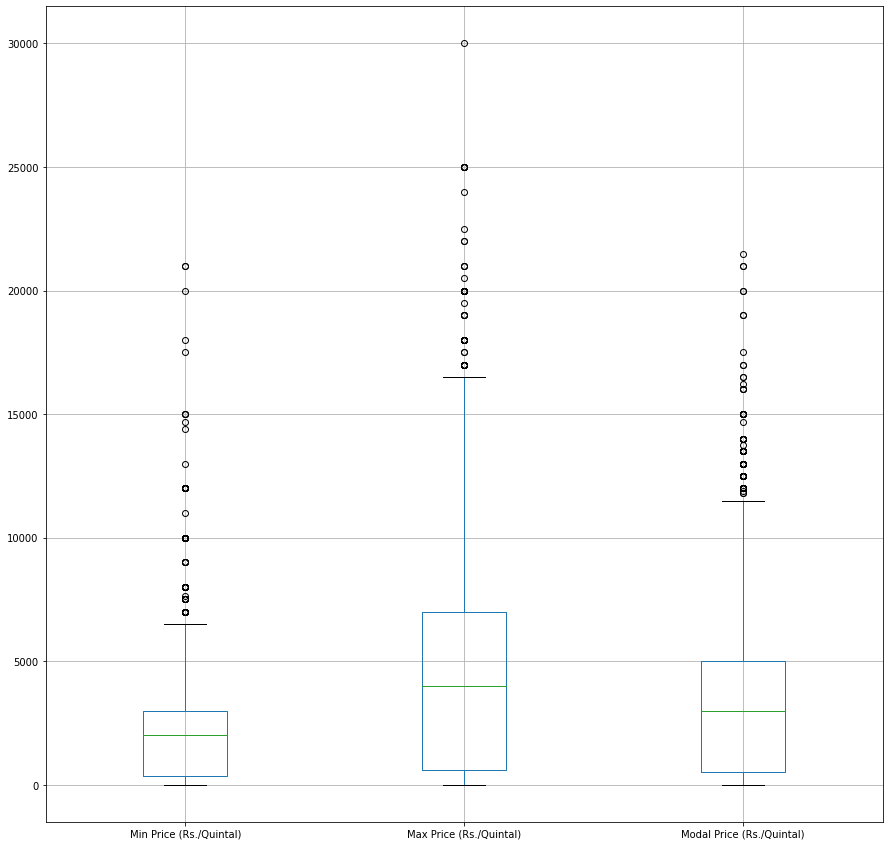

In [1060]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
data.boxplot()

In [1061]:
from numpy import where
def imp_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    IQR = q3 -q1 
    upper = data[~(data>(q3+1.5*IQR))].max()
    lower = data[~(data<(q1-1.5*IQR))].min()
    feature = where(data>upper, data.mean(), where(data<lower, data.mean(), data))
    return feature

for col in data_dup.columns:
    data[col] = imp_iqr(data_dup[col])


<Axes: >

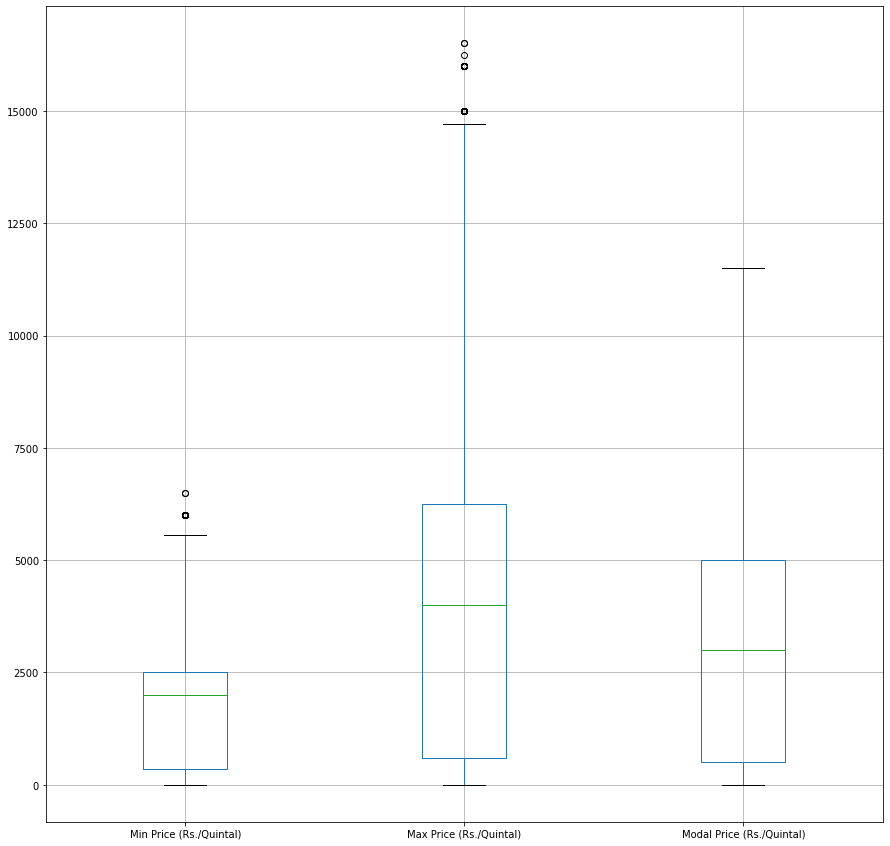

In [1062]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
data.boxplot()

In [1063]:
# Filter data for a specific crop variety
#crop_data = data[data['Commodity'] == 'Ginger']  # Replace 'Cotton' with the desired crop variety

# Select relevant columns and convert 'Price Date' to datetime
crop_data = data[['Price Date', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']]
crop_data['Price Date'] = pd.to_datetime(crop_data['Price Date'])

# Sort by 'Price Date'
crop_data = crop_data.sort_values(by='Price Date')

In [1064]:
crop_data

,Price Date,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
383,2012-01-02,2000.000000,3500.0,2500.0
382,2012-01-04,2000.000000,5000.0,3000.0
2033,2012-01-04,2000.000000,4000.0,3000.0
2032,2012-01-05,2000.000000,5000.0,3500.0
2031,2012-01-06,2000.000000,4000.0,3000.0
...,...,...,...,...
1588,2022-12-29,1000.000000,2500.0,1750.0
387,2022-12-30,3500.000000,15000.0,9300.0
1587,2022-12-30,1000.000000,2500.0,1750.0
2826,2022-12-31,80.000000,200.0,170.0


In [1065]:
# Feature engineering - create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])
    return np.array(sequences), np.array(targets)

sequence_length = 10  # Define the sequence length for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(crop_data[['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)']])

In [1066]:
# Create sequences and targets
sequences, targets = create_sequences(scaled_data, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.3, random_state=42)


In [1067]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 3)))
model.add(Dense(3))  # Output layer with 3 neurons for Min Price, Max Price, and Modal Price
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse',metrics=['accuracy'])  # Mean Squared Error loss function

# Train the model
his = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
79/79 [==============================] - 4s 14ms/step - loss: 0.0445 - accuracy: 0.4544 - val_loss: 0.0390 - val_accuracy: 0.3629
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0406 - accuracy: 0.4901 - val_loss: 0.0426 - val_accuracy: 0.5420
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0407 - accuracy: 0.4786 - val_loss: 0.0391 - val_accuracy: 0.5078
Epoch 4/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.5222 - val_loss: 0.0396 - val_accuracy: 0.5882
Epoch 5/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0390 - accuracy: 0.5464 - val_loss: 0.0402 - val_accuracy: 0.5734
Epoch 6/100
79/79 [==============================] - 0s 6ms/step - loss: 0.0393 - accuracy: 0.5289 - val_loss: 0.0382 - val_accuracy: 0.5826
Epoch 7/100
79/79 [==============================] - 1s 6ms/step - loss: 0.0389 - accuracy: 0.5392 - val_loss: 0.0394 - val_accuracy: 0.5586
Epoch 8/100


In [1068]:
print(his.history['accuracy'])

[0.45443740487098694, 0.4900950789451599, 0.47860538959503174, 0.5221869945526123, 0.5463550090789795, 0.5289223194122314, 0.5392234325408936, 0.5249603986740112, 0.5166402459144592, 0.5467512011528015, 0.5245642066001892, 0.5285261273384094, 0.5063391327857971, 0.5174326300621033, 0.4885103106498718, 0.5439777970314026, 0.5198098421096802, 0.5352615118026733, 0.5075277090072632, 0.5253565907478333, 0.5289223194122314, 0.5257527828216553, 0.5285261273384094, 0.5352615118026733, 0.5348653197288513, 0.5178288221359253, 0.5511093735694885, 0.5348653197288513, 0.5491283535957336, 0.5439777970314026, 0.5526941418647766, 0.5427892208099365, 0.5198098421096802, 0.5423930287361145, 0.5463550090789795, 0.5570523142814636, 0.5499207377433777, 0.5237717628479004, 0.5427892208099365, 0.5574485063552856, 0.5546751022338867, 0.5522979497909546, 0.5479397773742676, 0.5542789101600647, 0.5451663732528687, 0.5546751022338867, 0.5332804918289185, 0.5554674863815308, 0.5550712943077087, 0.552694141864776

In [1069]:
# Evaluate the model on the test set
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)  # Inverse transform to get actual prices
y_test = scaler.inverse_transform(y_test)

In [1070]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 1736.6130990138536
Root Mean Squared Error (RMSE): 2400.3388245911738


In [1071]:
for i in range(len(y_test)):
    print(y_test[i], test_predictions[i])

[ 2000. 13000.  7500.] [4001.66  8962.177 7966.989]
[2500. 6000. 5000.] [1140.4005 2982.4685 1874.4889]
[2000. 3750. 3150.] [1578.5255 4388.4336 2760.0833]
[ 80. 200. 180.] [1646.9312 3324.279  2633.7593]
[1750. 2500. 2500.] [1513.4897 3292.674  2774.0476]
[2265.5382914  4916.4387614  3555.83466962] [1067.7572 2345.8901 1721.6259]
[ 50. 150. 100.] [1246.2479 2074.6804 1944.7357]
[ 5000. 13000.  9000.] [ 5134.8022 14590.899  10215.714 ]
[3000. 4500. 4500.] [1586.1271 2627.7463 2047.2184]
[1000. 3000. 2000.] [1225.8971 2714.8906 1963.6917]
[ 2265.5382914  14000.          3555.83466962] [ 2811.0955 11930.227   5883.2856]
[1500. 4000. 3000.] [1225.9819 2816.5444 2019.921 ]
[100. 120. 110.] [1393.417  1764.6509 1461.4213]
[1300. 3500. 2000.] [1343.1127 3173.5232 2195.5786]
[2000. 2000. 2000.] [1179.2247 2210.2583 1704.9794]
[3000. 4500. 3500.] [1921.5656 3210.491  2979.3086]
[ 500. 2500. 1500.] [722.2211  922.54126 704.96844]
[ 750. 1350. 1000.] [1245.9565 2849.8965 2081.7275]
[5500. 6000. 

In [1072]:
results_df = pd.DataFrame({
    'Actual_Min_Price': y_test[:, 0],      # Assuming Min Price is the first column in y_test
    'Actual_Max_Price': y_test[:, 1],      # Assuming Max Price is the second column in y_test
    'Actual_Modal_Price': y_test[:, 2],    # Assuming Modal Price is the third column in y_test
    'Predicted_Min_Price': test_predictions[:, 0],
    'Predicted_Max_Price': test_predictions[:, 1],
    'Predicted_Modal_Price': test_predictions[:, 2]
})

# Save the DataFrame to a CSV file
results_df.to_csv('actual_vs_predicted_test_set.csv', index=False)

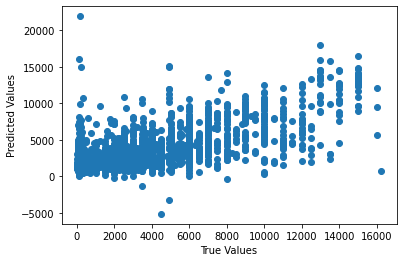

In [1073]:
import matplotlib.pyplot as plt

plt.scatter(y_test, test_predictions)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

In [1074]:
# Predicting future prices (adjust this based on your requirement)
future_data = scaled_data[-sequence_length:]  # Take the last sequence from the dataset
future_sequence = future_data.reshape((1, sequence_length, 3))  # Reshape for prediction
future_prediction = model.predict(future_sequence)
future_prediction = scaler.inverse_transform(future_prediction)  # Inverse transform to get actual prices

print("Predicted Min Price:", future_prediction[0][0])
print("Predicted Max Price:", future_prediction[0][1])
print("Predicted Modal Price:", future_prediction[0][2])

Predicted Min Price: 2525.8225
Predicted Max Price: 8591.576
Predicted Modal Price: 5604.3135


In [1075]:
#model.save('gram.h5')